<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/data_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!pip install wandb more_itertools
!git clone https://github.com/Krankile/npmf.git

In [3]:
# https://wandb.ai/authorize
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## General setup

In [4]:
%%capture
!cd npmf && git pull

import math
import multiprocessing
import os
import pickle
import random
from collections import Counter, defaultdict
from dataclasses import asdict, dataclass
from datetime import datetime, timedelta
from operator import itemgetter
from typing import Callable, List, Tuple
from functools import partial
from glob import glob
from enum import Enum
from pathlib import Path

from more_itertools import chunked

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from npmf.utils import Problem
from npmf.utils.colors import main, main2, main3
from npmf.utils.dataset import EraDataset, EraController
from npmf.utils.dataset.utils import clamp_and_slice
from npmf.utils.dtypes import fundamental_types
from npmf.utils.eikon import column_mapping
from npmf.utils.tests.utils import pickle_df
from npmf.utils.wandb import get_datasets, put_dataset, put_nn_model, get_processed_data
from npmf.utils.training import EarlyStop, to_device, TqdmPostFix, loss_fns, get_naive_pred
from npmf.utils.models import models

from numpy.ma.core import outerproduct
from pandas.tseries.offsets import BDay, Day
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from torch import nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset

import wandb as wb

In [5]:
np.seterr(all="raise")

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (6, 4)  # (6, 4) is default and used in the paper

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [7]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [8]:
pre_proc_data_dir = None
np.random.seed(69)


# Get some data

In [9]:
%%capture
reload_data = not True

if reload_data or not "stock_df" in vars():
    names = ["stock-data:final", "fundamental-data:final", "meta-data:final", "macro-data:final"]

    stock_df, fundamental_df, meta_df, macro_df = get_datasets(names=names, project="master")

    stock_df = stock_df.drop(columns=["close_price", "currency"]).astype({"market_cap": np.float32})
    fundamental_df = fundamental_df.drop(columns="period_end_date").astype(fundamental_types)
    macro_df.iloc[:, 1:] = macro_df.iloc[:, 1:].astype(np.float32)

In [10]:
fundamental_df

,ticker,date,announce_date,revenue,gross_profit,ebitda,ebit,net_income,fcf,total_assets,total_current_assets,total_liabilites,total_current_liabilities,long_term_debt_p_assets,short_term_debt_p_assets,gross_profit_p_revenue,ebitda_p_revenue,ebit_p_revenue,net_income_p_revenue,fcf_p_revenue
0,OMVV.VI,2000-06-30,2000-10-23,1.591395e+09,230190752.0,181045440.0,105530000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.144647,0.113765,0.066313,NaN,NaN
1,OMVV.VI,2000-12-31,2001-04-30,1.938099e+09,372273984.0,228378016.0,132398360.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.192082,0.117836,0.068314,NaN,NaN
2,OMVV.VI,2001-03-31,2001-11-15,1.675755e+09,270127136.0,246253936.0,174937920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.161197,0.146951,0.104394,NaN,NaN
3,OMVV.VI,2001-06-30,2001-11-15,1.704178e+09,261593376.0,199438288.0,139758656.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.153501,0.117029,0.082009,NaN,NaN
4,OMVV.VI,2001-09-30,2001-11-08,1.692967e+09,247022000.0,223213424.0,133206040.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.145911,0.131848,0.078682,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97261,QNBFL.IS,2020-12-31,2021-01-27,2.256163e+07,23938962.0,19901776.0,19684876.0,4358783.5,-55370640.0,1.054091e+09,976299840.0,914465408.0,0.0,79.434418,16.241480,1.000000,0.882107,0.872494,0.193195,-2.454195
97262,QNBFL.IS,2021-03-31,2021-04-27,2.204066e+07,23938962.0,19429518.0,19229734.0,5300726.0,2229011.5,1.013960e+09,976299840.0,883333376.0,0.0,78.558853,16.241480,1.000000,0.881531,0.872466,0.240498,0.101132
97263,QNBFL.IS,2021-06-30,2021-07-28,2.247148e+07,23938962.0,19866148.0,19660604.0,5087400.0,-19495676.0,1.019194e+09,976299840.0,890567936.0,0.0,46.784729,23.343519,1.000000,0.884061,0.874914,0.226394,-0.867574
97264,QNBFL.IS,2021-09-30,2021-10-26,2.341440e+07,23938962.0,20764106.0,20558956.0,5429178.0,-11886505.0,1.087815e+09,976299840.0,956602944.0,0.0,57.436150,17.600700,1.000000,0.886809,0.878048,0.231874,-0.507658


# Bankrupcy experiments

In [77]:
bankruptcy_df = pd.DataFrame(fundamental_df[["ticker", "announce_date"]])

In [78]:
bankruptcy_df["insolvency"] = fundamental_df["total_assets"] / fundamental_df["total_liabilites"]
bankruptcy_df["illiquid"] = (fundamental_df["total_current_assets"] / fundamental_df["total_current_liabilities"]).replace(np.inf, 0)

In [79]:
bankruptcy_df["bankrupt"] =  (1 > bankruptcy_df["insolvency"]) & (1 > bankruptcy_df["illiquid"]) 

In [80]:
bankruptcy_df["year"], bankruptcy_df["month"] = bankruptcy_df.announce_date.dt.year, bankruptcy_df.announce_date.dt.month

In [81]:
percentage_bankrupt_over_time = bankruptcy_df.groupby(by=["year", "month"])[["bankrupt"]].mean()


,bankrupt
year,
2000,0
2001,0
2002,2
2003,2
2004,3
2005,8
2006,8
2007,7
2008,10


In [82]:
percentage_bankrupt_over_time["day"] = 1

In [83]:
percentage_bankrupt_over_time = percentage_bankrupt_over_time.reset_index()
percentage_bankrupt_over_time

,year,month,bankrupt,day
0,2000,1,0.000000,1
1,2000,2,0.000000,1
2,2000,3,0.000000,1
3,2000,4,0.000000,1
4,2000,5,0.000000,1
...,...,...,...,...
264,2022,1,0.007576,1
265,2022,2,0.011713,1
266,2022,3,0.017647,1
267,2022,4,0.010526,1


In [85]:
percentage_bankrupt_over_time["plot_date"] = pd.to_datetime(percentage_bankrupt_over_time.iloc[:,[0,1,3]])

In [86]:
percentage_bankrupt_over_time

,year,month,bankrupt,day,plot_date
0,2000,1,0.000000,1,2000-01-01
1,2000,2,0.000000,1,2000-02-01
2,2000,3,0.000000,1,2000-03-01
3,2000,4,0.000000,1,2000-04-01
4,2000,5,0.000000,1,2000-05-01
...,...,...,...,...,...
264,2022,1,0.007576,1,2022-01-01
265,2022,2,0.011713,1,2022-02-01
266,2022,3,0.017647,1,2022-03-01
267,2022,4,0.010526,1,2022-04-01


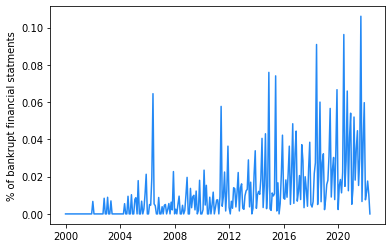

In [89]:
plt.ylabel("% of bankrupt financial statments")
plt.plot(percentage_bankrupt_over_time["plot_date"], percentage_bankrupt_over_time["bankrupt"]);

In [109]:
bankrupt_per_year = (bankruptcy_df.groupby(by=["ticker", "year"])[["bankrupt"]].sum() > 0).reset_index().groupby("year").sum()
bankrupt_percentage_per_year = (bankruptcy_df.groupby(by=["ticker", "year"])[["bankrupt"]].sum() > 0).reset_index().groupby("year").mean()

In [102]:
bakrupt_per_year

,bankrupt
year,
2000,0
2001,0
2002,2
2003,2
2004,3
2005,8
2006,8
2007,7
2008,10


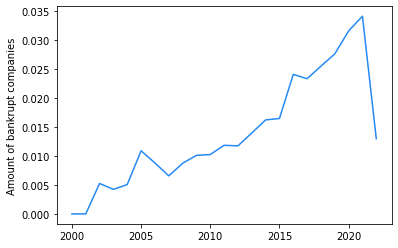

In [110]:
plt.ylabel("Amount of bankrupt companies")
plt.plot(bankrupt_percentage_per_year.index, bankrupt_percentage_per_year.values);

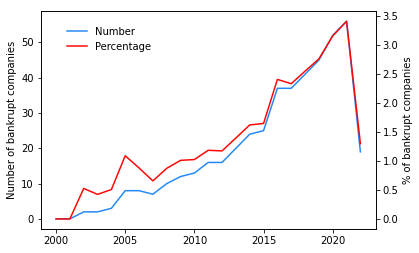

In [122]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.set_ylabel("Number of bankrupt companies")
ax.plot(bankrupt_per_year.index, bankrupt_per_year.values, label="Number")


ax2.set_ylabel("% of bankrupt companies")
ax2.plot(bankrupt_percentage_per_year.index, bankrupt_percentage_per_year.values*100, color=main2, label="Percentage");

fig.legend(loc=(0.15,0.78), frameon=False);

In [95]:
print(f"The total amount of bankrupt financial statements: {1203/97266:.2%}")

The total amount of bankrupt financial statements: 1.24%
